In [1]:
!pip install Sastrawi

In [2]:
import pandas as pd
import numpy as np
import re

from transformers import AutoTokenizer,AutoModelForSequenceClassification
from transformers import pipeline

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

import os
import json

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv("perceraian.csv", delimiter=";")
df.head()

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url
0,Wed Dec 13 11:31:41 +0000 2023,1734898883548111067,— kehidupan pasca perceraian https://t.co/9T...,0,0,0,0,in,418543250,1673189134960308226,kethatey,https://twitter.com/kethatey/status/1734898883...
1,Wed Dec 13 11:20:34 +0000 2023,1734896085653655969,@pagibulanjuni Begitulah kehidupan pasca perce...,0,1,0,0,in,1103686384471048194,1734868215703228865,seventhlilac,https://twitter.com/seventhlilac/status/173489...
2,Wed Dec 13 10:20:47 +0000 2023,1734881041717088280,@tanyarlfes Polisi Benarkan Ammar Zoni Dtangka...,0,0,0,0,in,1145131153289908225,1734845473046032404,diaryCLLe,https://twitter.com/diaryCLLe/status/173488104...
3,Wed Dec 13 10:20:16 +0000 2023,1734880912020807779,@milkywaygyal @18fesss Sekarang kl kasus si se...,0,1,0,0,in,83037325,1734874645776806279,bowbows,https://twitter.com/bowbows/status/17348809120...
4,Wed Dec 13 10:11:59 +0000 2023,1734878827430699455,@dacdelions @taebybyby @hayateea11 @jounnast @...,0,0,0,0,in,1664876228401303554,1734791529062101262,aniblogsan52394,https://twitter.com/aniblogsan52394/status/173...


## Preprocessing

### case folding

In [4]:
def case_folding(tweet):
 # menghapus non-ASCII (emoticon, chinese word, .etc)
 tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
 # merubah ke lowercase
 tweet = str(tweet).lower()
 # menghapus tab, new line, dan back slice
 tweet = tweet.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
 # menghapus mention
 tweet = re.sub(r'\@([\w]+)',' ', tweet)
 # menghapus link
 tweet = re.sub(r'http[s]?\:\/\/.[a-zA-Z0-9\.\/\_?=%&#\-\+!]+',' ', tweet)
 tweet = re.sub(r'pic.twitter.com?.[a-zA-Z0-9\.\/\_?=%&#\-\+!]+',' ', tweet)
 # menghapus hashtag
 tweet = re.sub(r'\#([\w]+)',' ', tweet)
 # menghapus incomplete URL
 tweet = tweet.replace("http://", " ").replace("https://", " ")
 # menghapus punctuation
 tweet = re.sub(r'[^\w\s]', ' ', tweet)
 # menghapus semua non char 48
 tweet = ' '.join((re.sub(r'[^\w]', ' ', tweet).split()))
 # menghapus angka
 tweet = re.sub(r"\d+", "",tweet)
 # menghapus multiple whitespace
 tweet = re.sub('\s+',' ',tweet)
 # menghapus single karakter
 tweet = re.sub(r"\b[a-zA-Z]\b", "",tweet)
 #spasi ganda (atau lebih) menjadi satu spasi
 tweet = re.sub(' +', ' ', tweet)
 # menghapus whitespace leading & trailing
 tweet = str(tweet).strip(" ")
 # menghapus titik yang berulang
 tweet = re.sub(r'\.{2,}', '', tweet)

 return tweet

In [5]:
df = df.drop(["created_at","id_str", "quote_count", "reply_count", "retweet_count", "favorite_count", "lang", "user_id_str", "conversation_id_str", "username", "tweet_url"], axis=1)

df["clean_text"] = df["full_text"].apply(case_folding)

### Tokenizing

In [6]:
# Tokenize data tweet
df['tokenize_text'] = df["clean_text"].apply(word_tokenize)

### Normalization

In [7]:
normalization_text = pd.read_csv('colloquial-indonesian-lexicon.csv', delimiter=',')

slang_dict = normalization_text.set_index('slang')['formal'].to_dict()

In [8]:
def normalization(document):
    new_words = []
    for word in document:
        if word in slang_dict:
            new_words.append(slang_dict[word])
        else:
            new_words.append(word)
    return new_words

df["normalize_text"] = df["tokenize_text"].apply(normalization)

### stopword

In [9]:
list_stopwords = stopwords.words("indonesian")

def remove_stopword(words):
    new_words = []
    for word in words:
        if word in list_stopwords:
            continue
        else:
            new_words.append(word)
    return new_words

df["stopword_text"] = df["normalize_text"].apply(remove_stopword)

### Stemming

In [10]:
folder_path = "./"  # Ganti dengan path folder yang sesuai

file_name = "term_dict.json"

file_path = os.path.join(folder_path, file_name)

if os.path.isfile(file_path):
    with open(file_path, 'r') as file:
        # Load the JSON data into a dictionary
        term_dict = json.load(file)
        print("term dict sudah ada!")
else:
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # fungsi stemming
    def stemming(term):
        return factory.create_stemmer().stem(term)

    # membuat dictionary dengan key tiap kata yang ada dalam data
    term_dict = {}
    count = 0
    for document in df['stopword_text']:
        if(count % 100 == 0):
            print("data ke-", count)
        for term in document:
            if term not in term_dict:
                term_dict[term] = stemming(term)
        count += 1

# fungsi iterasi tiap kata untuk dilakukan stemming
def get_stemmed_word_value(words):
 return [term_dict[term] for term in words]

term dict sudah ada!


In [11]:
df["stemming_text"] = df["stopword_text"].apply(get_stemmed_word_value)

## labeling

In [12]:
model_path = "w11wo/indonesian-roberta-base-sentiment-classifier"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Inisialisasi variabel model
analyzer = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

def analize_tweet_sentiment(tweet):
 analysis = analyzer(tweet)
 label_result = analysis[0]['label']
 return analysis[0]['label']

In [13]:
df["sentiment"] = df["normalize_text"].apply(lambda x: " ".join(x)).apply(analize_tweet_sentiment)

### Result

In [14]:
data = pd.DataFrame(df["stemming_text"])
data["sentiment"] = df["sentiment"]
data.head()

,stemming_text,sentiment
0,"[hidup, pasca, cerai]",positive
1,"[hidup, pasca, cerai]",positive
2,"[polisi, benar, ammar, zoni, dtangkap, kait, n...",negative
3,"[kalo, sih, sender, rugi, turut, kalo, jalan, ...",negative
4,"[hak, hidup, manusia, untung, untung, pasang, ...",positive


## Word Cloud

In [16]:
def all(array):
  bank_words = ""
  for word in array:
      word = str(word)
      bank_words += " ".join(word)
  print(bank_words)

comment_words = df["stemming_text"].apply(lambda x: " ".join(x))

In [20]:
bank_words = ""
np.array(comment_words)

for i in range (1513):
  bank_words += comment_words[i]+" "

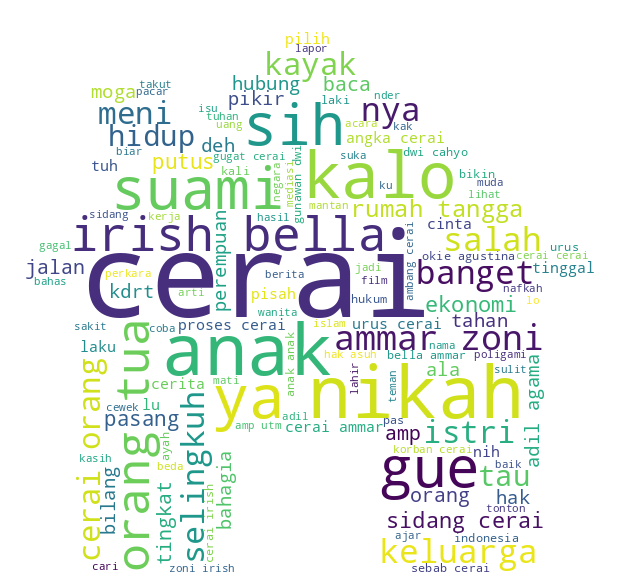

In [21]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image
import requests

stopwords = set(STOPWORDS)

pic = np.array(Image.open(requests.get('http://www.clker.com/cliparts/O/i/x/Y/q/P/yellow-house-hi.png',stream=True).raw))
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords, mask = pic,
                min_font_size = 10)
wordcloud.generate(bank_words)

plt.figure(figsize = (6, 6), facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

## Model Selection

### Separate Feature and Class

In [15]:
# Menghapus data kosong jika ada
data = data.dropna()

X = data["stemming_text"].apply(lambda x: " ".join(x))
y = data["sentiment"]
y.head()

0    positive
1    positive
2    negative
3    negative
4    positive
Name: sentiment, dtype: object

### Label Encoding

In [16]:
encoder = LabelEncoder()

y = encoder.fit_transform(y)
print(y[:5])

[2 2 0 0 2]


### Splitting Dataset

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)

### Feature Extraction

In [18]:
# Inisialisasi vectorizer
countVectorizer = CountVectorizer(binary=True)
# Membuat matrix frekuensi kemunculan setiap kata menggunakan vectorizer
x_train_vec = countVectorizer.fit_transform(X_train).toarray()
x_test_vec = countVectorizer.transform(X_test).toarray()

### Random Forest

In [19]:
rf = RandomForestClassifier(n_estimators=150, criterion="entropy", min_samples_split=7,
                            min_samples_leaf=2, random_state=42)

In [20]:
rf.fit(x_train_vec, y_train)

y_predict = rf.predict(x_test_vec)
score = accuracy_score(y_test, y_predict)

print("Random Forest train accuracy: {:.2f} %".format(rf.score(x_train_vec, y_train)*100))
print("Random Forest test accuracy: {:.2f} %".format(score*100))

Random Forest train accuracy: 80.55 %
Random Forest test accuracy: 70.26 %


## Model Evaluation

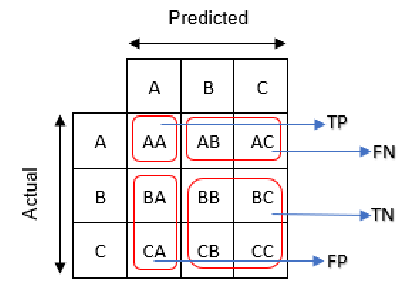

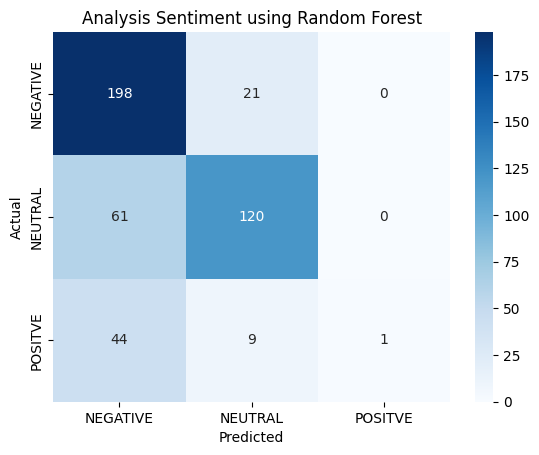

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_predict)

classes = ['NEGATIVE', 'NEUTRAL', 'POSITVE']
title = 'Analysis Sentiment using Random Forest'

# sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%',
#             cmap='Blues', xticklabels=classes, yticklabels=classes)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(title)
plt.show()

In [23]:
# precision, recall, dan f1-score untuk class positive
TP = cf_matrix[2][2]
FP = cf_matrix[0][2] + cf_matrix[1][2]
TN = cf_matrix[0][0] + cf_matrix[0][1] + cf_matrix[1][0] + cf_matrix[1][1]
FN = cf_matrix[2][0] + cf_matrix[2][1]

precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = 2 * precision*recall / (precision+recall)

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("f1-score: {:.2f}".format(f1_score))

Precision: 1.00
Recall: 0.02
f1-score: 0.04


In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict, target_names=classes))

              precision    recall  f1-score   support

    NEGATIVE       0.65      0.90      0.76       219
     NEUTRAL       0.80      0.66      0.73       181
     POSITVE       1.00      0.02      0.04        54

    accuracy                           0.70       454
   macro avg       0.82      0.53      0.51       454
weighted avg       0.75      0.70      0.66       454



In [25]:
df["sentiment"].value_counts()

negative    743
neutral     578
positive    192
Name: sentiment, dtype: int64

In [26]:
pd.DataFrame(y_train).value_counts()

0    524
1    397
2    138
dtype: int64

In [27]:
pd.DataFrame(y_test).value_counts()

0    219
1    181
2     54
dtype: int64